In [1]:
##################
from dataset.preparation import convert_type, convert_to_gigital_target
from dataset.preprocessing import prepare_dataset
import pandas as pd
import numpy as np
from sklearn.utils import resample

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



In [2]:
csv = '/Users/alinakozyreva/Documents/MIPT/3_семестр/ВКР/datasets/CIC_IOT_Dataset2023/csv/part-00164-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'

In [3]:
df = pd.read_csv(csv)
df = convert_to_gigital_target(df, classification_type='group')
df = convert_type(df)

In [4]:
trainloaders, validationloaders, testloader = prepare_dataset(df, 
                                                              mode='EXCLUDE_SINGLE_ATTACK',  #'STRATIFIED' 'SINGLE_ATTACK' 'RANDOM' 'EXCLUDE_SINGLE_ATTACK' 'HALF_BENIGN'
                                                              normalization='StandardScaler',
                                                              feature_extractor=None,
                                                              num_features=46,
                                                              num_partitions=10,
                                                              max_partitions_size=500_000,
                                                              batch_size=64,
                                                              val_ratio=0.2
)

Counter({1: 325396, 2: 77652, 3: 25516, 0: 10687, 5: 4703, 4: 3340, 6: 231, 7: 113})
447638


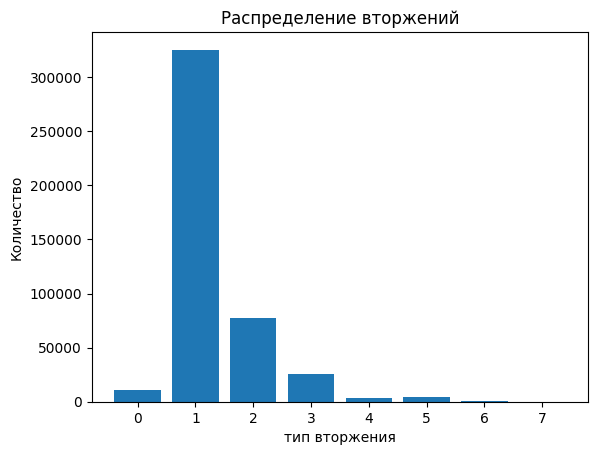

In [5]:
from collections import Counter
from matplotlib import pyplot as plt

print(Counter(df['label']))
data = Counter(df['label'])
print(sum(data.values()))

labels, values = zip(*data.items())

fig, ax = plt.subplots()
ax.bar(labels, values)

ax.set_xlabel('тип вторжения')
ax.set_ylabel('Количество')
ax.set_title('Распределение вторжений')

plt.show()

# Preparing the experiment



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

We'll be training the model in a Federated setting. In order to do that, we need to define two functions:

* `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.

In [7]:
class Net(nn.Module): 
    def __init__(self, 
                 num_classes: int=8): # input_size = 46 number of features
        super(Net, self).__init__()
        self.lstm = nn.LSTM(
            input_size=46,
            hidden_size=32,
            bidirectional=True,
        )
       
        self.fc = nn.Linear(32 * 2, num_classes)

    def forward(self, x):
        x = x.transpose(0, 1) # (sequence_length, batch_size, input_size)
        r_out, (h_n, h_c) = self.lstm(x)
        r_out = r_out[-1]  
        model = self.fc(r_out) 
        return model

In [8]:
net = Net(num_classes=8)

In [9]:
print(net)
print(net.parameters)
total = sum([param.nelement() for param in net.parameters()])
print("Number of parameter: %.2fM" % (total / 1e6))

Net(
  (lstm): LSTM(46, 32, bidirectional=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)
<bound method Module.parameters of Net(
  (lstm): LSTM(46, 32, bidirectional=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)>
Number of parameter: 0.02M


In [10]:
def train(net, trainloader, optimizer, epochs, device):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    net.to(device)

    for _ in range(epochs):
        for features, labels in trainloader:
            features, labels = features.to(device), labels.to(device)
            features = features.view(-1, 1, 46).float() # for transformation
            labels = labels.long() ######
            optimizer.zero_grad()
            outputs = net(features)
            outputs = outputs.float() ######
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return net


def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0

    predicts = []
    all_labels = []

    net.eval()
    net.to(device)
    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(device), labels.to(device)
            features = features.view(-1, 1, 46).float()
            labels = labels.long() ######
            outputs = net(features)
            outputs = outputs.float() ######
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            #####
            # for metrics   
            # Collect predictions and true labels for later use in calculating metrics
            predicts += predicted.tolist()
            all_labels += labels.cpu().numpy().tolist()
    # accuracy = correct / len(testloader.dataset)
    accuracy = accuracy_score(all_labels, predicts)
    precision = precision_score(all_labels, predicts, average='weighted', zero_division=1)
    recall = recall_score(all_labels, predicts, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, predicts, average='weighted')
    
    return loss, accuracy, precision, recall, f1

In [11]:
import flwr as fl

Now let's defice our Flower Client class:

In [12]:
from collections import OrderedDict
from typing import Dict, List, Tuple

import torch
from flwr.common import NDArrays, Scalar


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, vallodaer) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = Net(num_classes=8)
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # read from config
        lr, epochs = config["lr"], config["epochs"]

        # Define the optimizer
        # optim = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        optim = torch.optim.Adam(self.model.parameters(), lr=lr)
        # do local training
        train(self.model, self.trainloader, optim, epochs=epochs, device=self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy, precision, recall, f1 = test(self.model, self.valloader, device=self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [13]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set """

        model = Net(num_classes=8)

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy, precision, recall, f1 = test(model, testloader, device)
        return loss, {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

    return evaluate_fn


# now we can define the strategy
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=0.1,
#     fraction_evaluate=0.1,
#     min_available_clients=100,
#     evaluate_fn=get_evaluate_fn(testloader), # Even this is not required
# )

In [14]:
from flwr.common import Metrics


def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 1,  # Number of local epochs done by clients
        "lr": 0.008, #0.01,  # Learning rate to use by clients during fit()
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

Now we can define our strategy:

In [15]:
# strategy = fl.server.strategy.FedAvg(
#     fraction_fit=0.5,  # Sample 10% of available clients for training
#     fraction_evaluate=0.1,  # Sample 5% of available clients for evaluation
#     min_fit_clients=5,  # Never sample less than 10 clients for training
#     min_evaluate_clients=4,  # Never sample less than 5 clients for evaluation
#     min_available_clients=int(
#         7
#     ),  # Wait until at least 75 clients are available
#     on_fit_config_fn=fit_config,
#     evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
#     evaluate_fn=get_evaluate_fn(testloader),  # global evaluation function
# )

# доступны все
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # Sample 10% of available clients for training
    fraction_evaluate=0.2,  # Sample 5% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        10
    ),  # Wait until at least 75 clients are available
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testloader),  # global evaluation function
)

In [16]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], vallodaer=valloaders[int(cid)]
        )

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, validationloaders)

In [17]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=10,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
)

INFO flwr 2023-12-06 00:07:40,220 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-12-06 00:07:42,175	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-06 00:07:43,451 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 3264027035.0, 'node:__internal_head__': 1.0, 'object_store_memory': 1632013516.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-12-06 00:07:43,457 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2023-12-06 00:07:43,460 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-12-06 00:07:43,541 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2023-12-06 00:07:43,545 | server.py:89 | Initializing global parameters
INFO flwr 2023-12-06 00:07:43,547 | server.py:276 | Requesting initial parameters from one r

history.metrics_centralized = {'accuracy': [(0, 0.15669958001965864), (1, 0.8132874631400232), (2, 0.8671700473594853), (3, 0.8397372888928604), (4, 0.8411223304441069), (5, 0.833504601912251), (6, 0.8357385398981324), (7, 0.843400947189706), (8, 0.843400947189706), (9, 0.843400947189706), (10, 0.843400947189706)], 'precision': [(0, 0.6941934802728142), (1, 0.7952389271568259), (2, 0.883833368966254), (3, 0.8633495937968636), (4, 0.8640159937161058), (5, 0.8597994858405247), (6, 0.8615873537607466), (7, 0.8673191995868662), (8, 0.8673191995868662), (9, 0.8673191995868662), (10, 0.8673191995868662)], 'recall': [(0, 0.15669958001965864), (1, 0.8132874631400232), (2, 0.8671700473594853), (3, 0.8397372888928604), (4, 0.8411223304441069), (5, 0.833504601912251), (6, 0.8357385398981324), (7, 0.843400947189706), (8, 0.843400947189706), (9, 0.843400947189706), (10, 0.843400947189706)], 'f1': [(0, 0.25396061914210843), (1, 0.7908443839037591), (2, 0.8398738989371509), (3, 0.7900141442111228), (

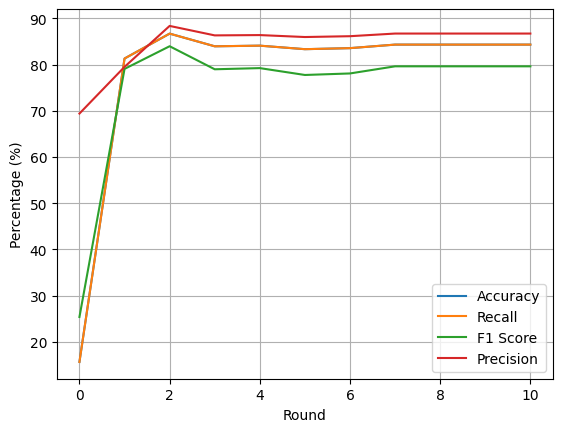

(raylet) [2023-12-06 00:13:45,240 E 11242 772141] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-12-06_00-07-40_283854_11156 is over 95% full, available space: 21596356608; capacity: 494384795648. Object creation will fail if spilling is required.


In [24]:
from matplotlib import pyplot as plt


print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_recall_centralised = history.metrics_centralized["recall"]
global_precision_centralised = history.metrics_centralized["precision"]
global_f1_centralised = history.metrics_centralized["f1"]


round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
recall = [100.0 * data[1] for data in global_recall_centralised]
precision = [100.0 * data[1] for data in global_precision_centralised]
f1 = [100.0 * data[1] for data in global_f1_centralised]

plt.plot(round, acc, label='Accuracy')
plt.plot(round, recall, label='Recall')
plt.plot(round, f1, label='F1 Score')
plt.plot(round, precision, label='Precision')

plt.grid()
plt.xlabel('Round')
plt.ylabel('Percentage (%)')
plt.legend()
plt.show()